In [54]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from bayes_opt import BayesianOptimization
from functions import calculate_metrics

# Load and prepare your data
df_all = pd.read_excel('All_data_correct.xlsx')
df_5_features = pd.read_excel('data-5features-all-outputs.xlsx')
df_30_features = pd.read_excel('data-30-features-all-outputs.xlsx')
df_all.drop(columns=["Responsibility", "Listening_skills", "Questioning_skills", "Team_participation", "Teamwork_oriented"], inplace=True)

df_se1 = df_all.loc[(df_all['country data collected'] == 'Sweden') & (df_all['Data source'] == 'Ericsson 2018')].reset_index(drop=True)
df_se2 = df_all.loc[(df_all['country data collected'] == 'Sweden') & (df_all['Data source'] == 'Ericsson 2020')].reset_index(drop=True)
df_bz = df_all.loc[(df_all['country data collected'] == 'Brazil') & (df_all['Data source'] == 'Brazil 2021')].reset_index(drop=True)
df_in = df_all.loc[df_all['country data collected'] == 'India'].reset_index(drop=True)

personality_names = list(df_30_features.iloc[:, :30])
bigfive_names = list(df_5_features.iloc[:, 2:7])
target = 'Team_Climate'
other_outputs = list(df_5_features.iloc[:, 7:-1])
X_5_features = df_all[bigfive_names]
X_30_features = df_all[personality_names]
y = df_all[target]

df_new = df_se2.copy()
# X = df_new[['Neuroticism']]
# y = df_new['Participative_safety']

X = df_new[bigfive_names] # Good results
y = df_new[target]



# Bayesian Optimization

In [55]:
# Split the data into training, validation, and testing sets (0.7, 0.15, 0.15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the function to optimize
def rf_cv(n_estimators, max_depth, min_samples_split, max_features):
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  max_features=min(max_features, 0.999),  # Fraction, must be <= 1.0
                                  random_state=42)
    
    return -1.0 * cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error").mean()

# Set the parameter bounds
param_bounds = {
    'n_estimators': (10, 250),
    'max_depth': (1, 50),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42
)
optimizer.maximize(init_points=5, n_iter=15)

# Get the best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])

# Train the final model with the best parameters
final_model = RandomForestRegressor(
    **best_params,
    random_state=42
)

# Merge the validation set with the training set
y_train = pd.concat([y_train, y_val])
X_train = pd.concat([X_train, X_val])
final_model.fit(X_train, y_train)
# Evaluate the final model on the test set
y_test_pred = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_test_pred)
score = final_model.score(X_test, y_test)
residuals = np.abs(y_test - y_test_pred)
mar = np.mean(residuals)

print(f"Test R^2 Score: {score}")
print(f"MAR: {mar:.4f}")
print(f"Final MSE on the test set: {final_mse:.4f}")

best_params_formatted = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'min_samples_split': int(best_params['min_samples_split']),
    'max_features': best_params['max_features']
}

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.2548    | 19.35     | 0.9547    | 18.84     | 153.7     |
| 2         | 0.247     | 8.645     | 0.2402    | 3.336     | 217.9     |
| 3         | 0.2654    | 30.45     | 0.7366    | 2.473     | 242.8     |
| 4         | 0.2575    | 41.79     | 0.2909    | 6.182     | 54.02     |
| 5         | 0.2592    | 15.91     | 0.5718    | 11.93     | 79.89     |
| 6         | 0.2695    | 30.77     | 0.7581    | 3.215     | 242.1     |
| 7         | 0.2699    | 32.76     | 0.7974    | 3.901     | 240.9     |
| 8         | 0.2714    | 29.7      | 0.8216    | 6.353     | 239.9     |
| 9         | 0.2636    | 31.64     | 0.5937    | 8.158     | 243.8     |
| 10        | 0.2725    | 29.56     | 0.999     | 2.738     | 237.2     |
| 11        | 0.2719    | 27.32     | 0.9494    | 6.356     | 233.5     |
| 12        | 0.2709    | 23.53     | 

In [56]:
best_params_formatted

{'n_estimators': 230,
 'max_depth': 31,
 'min_samples_split': 3,
 'max_features': 0.999}

In [57]:
optimized_rf = RandomForestRegressor(**best_params_formatted, random_state=42)
optimized_rf.fit(X_train, y_train)
y_pred = optimized_rf.predict(X_test)
residuals = np.abs(y_test - y_pred)
mar = np.mean(residuals)
score = optimized_rf.score(X_test, y_test)
mmre, mar, pred_25, r2, mae, mse, rmse = calculate_metrics(y_test, y_pred)
metrics = {'MMRE': mmre, 'MAR': mar, 'Pred(25)': pred_25, 'R2': r2,
                     'MAE': mae, 'MSE': mse, 'RMSE': rmse}

data = pd.DataFrame([metrics])

In [58]:
data

,MMRE,MAR,Pred(25),R2,MAE,MSE,RMSE
0,0.07029,0.280632,100.0,-0.065514,0.280632,0.151134,0.388759


# Hyperopt

In [47]:
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    score=mean_squared_error(y_test,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=500,rstate=np.random.default_rng(seed))
    return best

trial=Trials()
best=optimize(trial)

100%|██████████| 500/500 [11:44<00:00,  1.41s/trial, best loss: 0.12779262670433103] 


In [61]:
print(best)

{'max_depth': 10.526545355881362, 'min_samples_leaf': 2.0708933637149833, 'min_samples_split': 4.9462076787720255, 'n_estimators': 100.82984268553335}


In [62]:
TID=[t['tid'] for t in trial.trials]
Loss=[t['result']['loss'] for t in trial.trials]
maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
nest=[t['misc']['vals']['n_estimators'][0] for t in trial.trials]
min_ss=[t['misc']['vals']['min_samples_split'][0] for t in trial.trials]
min_sl=[t['misc']['vals']['min_samples_leaf'][0] for t in trial.trials]

hyperopt_rfr=pd.DataFrame({'tid':TID,'loss':Loss,
                          'max_depth':maxd,'n_estimators':nest,
                          'min_samples_split':min_ss, 'min_samples_leaf':min_sl})

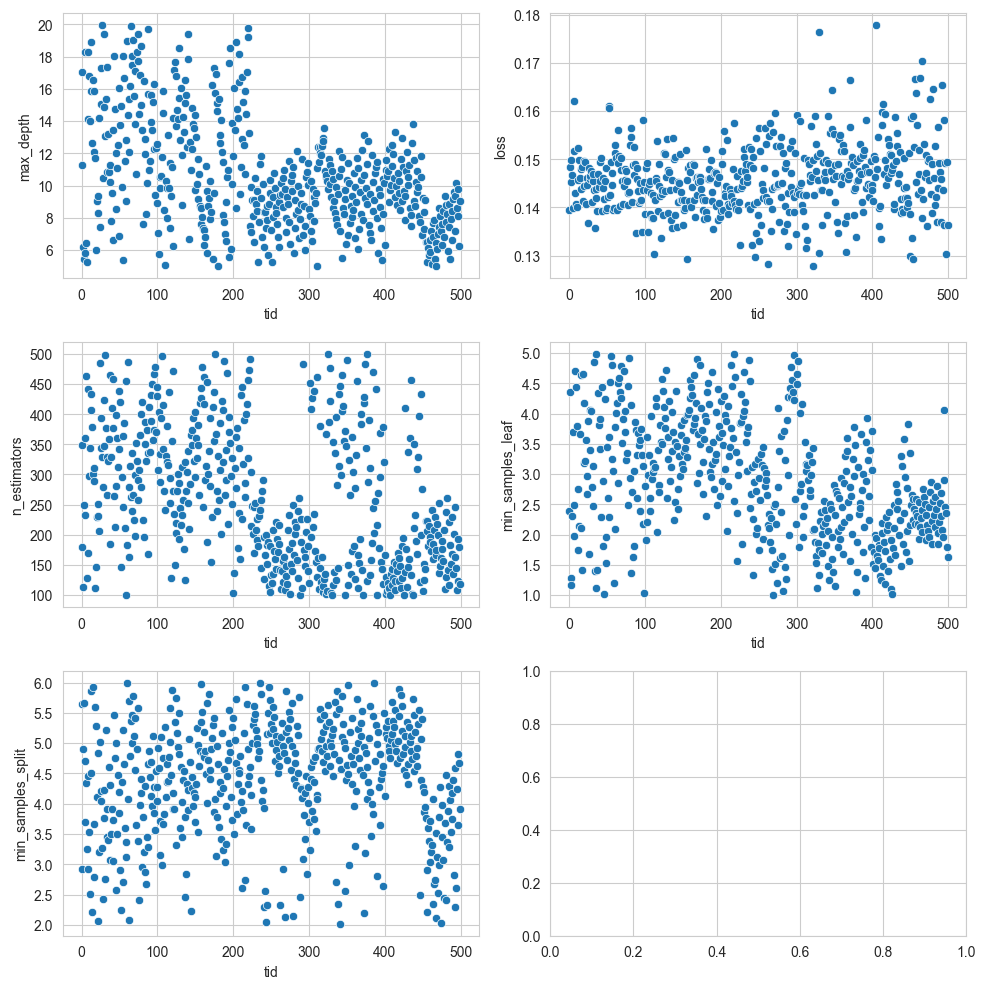

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(3,2,figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_rfr)
plt.subplot(3,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_rfr)
plt.subplot(3,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_rfr)
plt.subplot(3,2,4)
sns.scatterplot(x='tid',y='min_samples_leaf',data=hyperopt_rfr)
plt.subplot(3,2,5)
sns.scatterplot(x='tid',y='min_samples_split',data=hyperopt_rfr)

plt.tight_layout()